# 求解分段式刀片阱的电势分布

## 1.背景

求解分段式刀片阱的电势分布实际上是求解带有[Dirichlet边界条件](https://baike.baidu.com/item/%E8%BE%B9%E7%95%8C%E6%9D%A1%E4%BB%B6/7218954)的、刀片**外部**的Laplace问题。

假设$\Omega$是刀片**外部空间**，$\Omega$有12个边界，分别是RF刀片的2个表面$\Gamma_1,\Gamma_2$，和DC刀片的10个表面$\Gamma_i,i=3...12$。
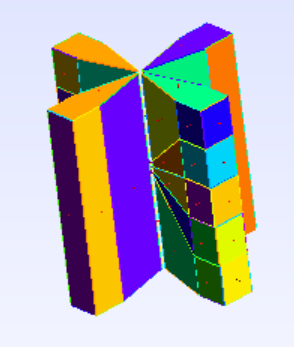

偏微分方程和边界条件如下：
$$ \Delta u=0 \quad in\space\Omega $$

$$u = f_i \quad on \space \Gamma_i$$
如果囚禁了离子，严格来说，空间中有净电荷，但是由于离子距离电极表面较远，而且电荷量很小，所以可以忽略离子带来的电势影响。
Laplace方程的Green函数形式如下：
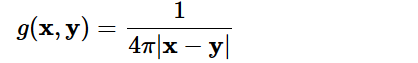
根据Green's representation theorm,$\Omega$外的简谐势场u满足：
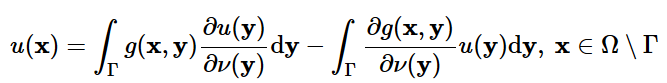
写成算符的形式
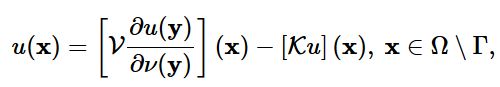

其中$V,K$是[single and double layer potential operators](https://bempp.com/2017/07/11/available_operators/)

取极限$\textbf{x}\rightarrow\Gamma$,得到边界积分方程
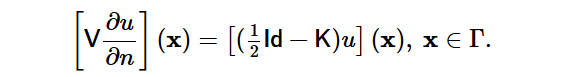
其中$V,K$是[single and double layer boundary operators](https://bempp.com/2017/07/11/available_operators/)

> ref:[Solving a Laplace problem with Dirichlet boundary conditions](http://nbviewer.jupyter.org/urls/bitbucket.org/bemppsolutions/bempp-tutorials/raw/master/notebooks/laplace_interior_dirichlet.ipynb)

## 2. 计算
首先导入bempp和numpy。bempp最好用docker方式安装，安装教程见[bempp官网docker安装](https://bempp.com/download/docker/)。
安装时要注意勾选Settings-Shared Drivers中的盘符C,D...（工作目录在哪个盘就勾选那个盘）,否则打开notebook后会显示没有权限创建notebook。
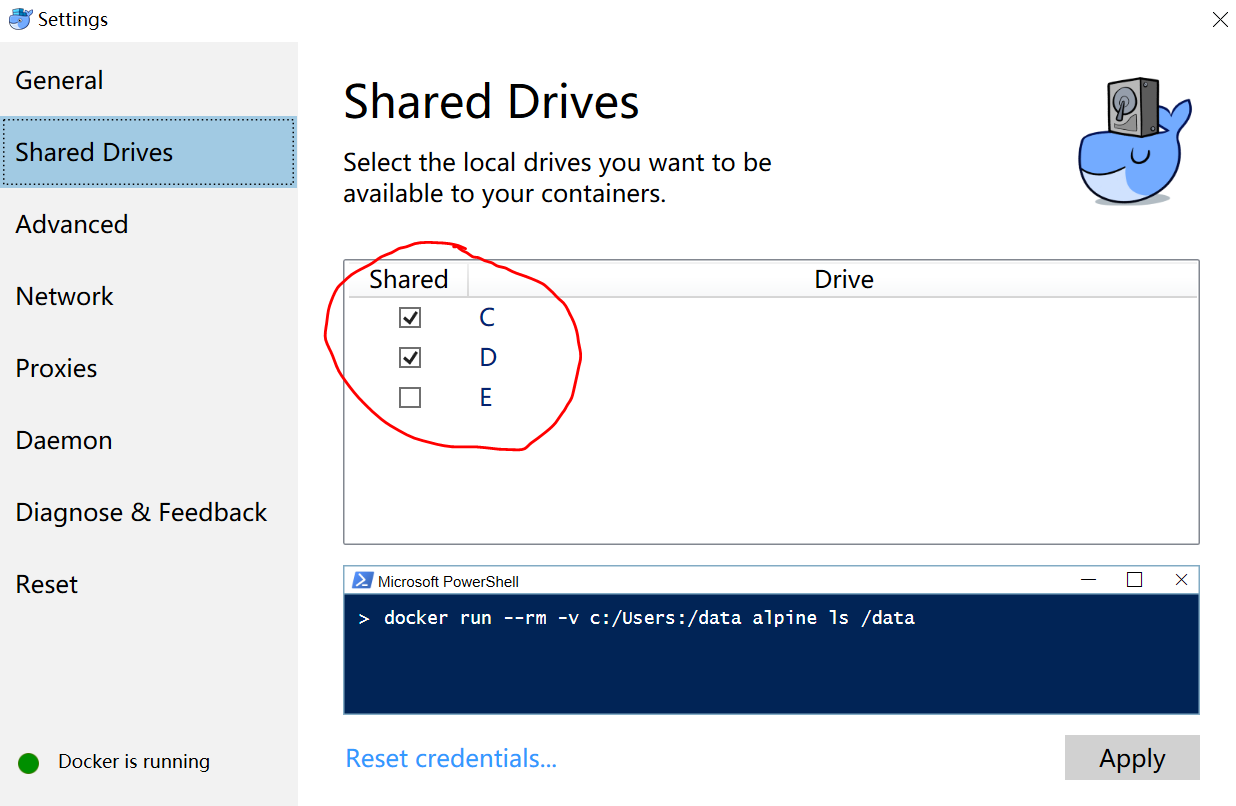

In [26]:
import bempp.api
import numpy as np

## 3.导入msh文件
这里用gmesh制作的msh网格文件，也可以用bempp自带的函数[grid tutorial](https://bempp.com/2017/07/06/grids-in-bempp)创建。个人建议用gmesh创建。
要检查网格文件是否合格：
- geo文件中surface的法向量是否朝外？
- msh文件中是否所有的surface都划分了网格？
- geo文件中是否**所有的面**都划分了physical group?
- geo文件中physical surface的标号是否正确？bempp把geo源文件中第一次出现的phsical surface的domain_index标为1,以此类推，而geo文件中的标号是我们自己定义的，所以domain_index和geo文件中的标号不一定是对应的。为了省去不必要的麻烦，我们就把geo文件中第一次出现的physical surface认为标记为1，标号要连续，与bempp认定的方式一致。

In [27]:
grid = bempp.api.import_grid('blade_start=10.msh')

设置grid画图环境，这里是ipython notebook

In [3]:
bempp.api.PLOT_BACKEND = "ipython_notebook"

In [4]:
grid.plot()

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## 4.定义space、operator
参考这个[notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/bemppsolutions/bempp-tutorials/raw/master/notebooks/laplace_interior_dirichlet.ipynb)，我也不懂。


In [28]:
# 定义space
dp0_space = bempp.api.function_space(grid, "DP", 0)
p1_space = bempp.api.function_space(grid, "P", 1)
# 定义operator
identity = bempp.api.operators.boundary.sparse.identity(
    p1_space, p1_space, dp0_space)
dlp = bempp.api.operators.boundary.laplace.double_layer(
    p1_space, p1_space, dp0_space)
slp = bempp.api.operators.boundary.laplace.single_layer(
    dp0_space, p1_space, dp0_space)

## 5.定义边界条件
这一步指定msh文件中的所有面的电势，即Dirichlet边界条件。
要清楚domain_index是怎么指定面的（上文有提到）。
RF刀片上加上高压，DC刀片上指定想设定的电压。

In [29]:
V0 = 200
def dirichlet_data(x, n, domain_index, result):
    global i
    if domain_index in [1, 2]:      # 在不同区域设置相应的电压
        result[0] = V0            #RF刀片加上高压
        
        
        
    elif domain_index in [3,7,8, 12]:
        result[0]=150
    elif domain_index in [4, 6, 9, 11]:
        result[0]=20                 #其他区域加偏置电压
    elif domain_index in [5, 10]:
        result[0]=100
    else:
        result[0]=0
        print "other"
        

dirichlet_fun = bempp.api.GridFunction(p1_space, fun=dirichlet_data)


画边界条件电势图

In [30]:
dirichlet_fun.plot()

A Jupyter Widget

A Jupyter Widget

## 6.解方程
We next assemble the right-hand side of the boundary integral equation, when solving interior $$(\tfrac12\mathsf{Id}+\mathsf{K})u.$$when solving exterior, $$(\tfrac12\mathsf{Id}-\mathsf{K})u.$$ The sign of $\mathsf{K}$ is related to the pointing normal on surface.

这里我们要求解的是外部电势，所以用第二个公式。注意这样计算的刀片内部的电势是错误的，画图时注意这一点。

以下两步运行时间较长。

In [31]:
%time rhs = (0.5 * identity - dlp) * dirichlet_fun  # solve exterior
# rhs.plot()

CPU times: user 22.4 s, sys: 80 ms, total: 22.5 s
Wall time: 6.46 s


**Typical run time**: CPU times: user 6min 23s, sys: 720 ms, total: 6min 24s
Wall time: 2min 10s

In [32]:
%time neumann_fun, info = bempp.api.linalg.gmres(slp, rhs, tol=1E-3)

CPU times: user 12min 19s, sys: 41.1 s, total: 13min
Wall time: 2min 57s


In [33]:
neumann_fun.plot()

A Jupyter Widget

A Jupyter Widget

In [46]:
bempp.api.export(grid_function=neumann_fun, file_name="neumann.msh")

**Typical run time**: CPU times: user 18min 55s, sys: 2min 45s, total: 21min 41s
Wall time: 7min 31s

## 7.画出电势图
至此，我们已经得到了全空间的电势分布。现在要画出感兴趣区域的电势分布。

## xy平面

In [34]:
n_grid_points = 100 # interested area分割细度
#plot_grid格式[(x1,y1), (x1, y2)
#              (x2,y1), (x2, y2)]的形式，详细的看这里https://www.cnblogs.com/NanShan2016/p/5491200.html
plot_grid = np.mgrid[-0.1:0.1:n_grid_points*1j,     # 指定x范围，1j不表示虚数，而是指grid包含两个端点。
                     -0.1:0.1:n_grid_points*1j]     # 指定y范围
z = 6 * np.ones(plot_grid[0].size)                    # 指定z平面
points = np.vstack((plot_grid[0].ravel(),             #ravel()将多维矩阵展成一维，返回视图。
                    plot_grid[1].ravel(),
                    z))

In [35]:
%%time
slp_pot = bempp.api.operators.potential.laplace.single_layer(
    dp0_space, points)
dlp_pot = bempp.api.operators.potential.laplace.double_layer(
    p1_space, points)
u_evaluated = slp_pot * neumann_fun - dlp_pot * dirichlet_fun

CPU times: user 1min 5s, sys: 0 ns, total: 1min 5s
Wall time: 11.2 s


## yz平面

In [36]:
#plot_grid格式[(x1,y1), (x1, y2)
#              (x2,y1), (x2, y2)]的形式，详细的看这里https://www.cnblogs.com/NanShan2016/p/5491200.html
yz_grid = np.mgrid[-0.1:0.1:n_grid_points*1j,     # 指定x范围，1j不表示虚数，而是指grid包含两个端点。
                     8:12:n_grid_points*1j]     # 指定y范围
                  # 指定z平面
yz_points = np.vstack((np.zeros(yz_grid[0].size),
                    yz_grid[0].ravel(),             #ravel()将多维矩阵展成一维，返回视图。
                    yz_grid[1].ravel()))

In [37]:
%%time
slp_pot = bempp.api.operators.potential.laplace.single_layer(
    dp0_space, yz_points)
dlp_pot = bempp.api.operators.potential.laplace.double_layer(
    p1_space, yz_points)
u_yz = slp_pot * neumann_fun - dlp_pot * dirichlet_fun

CPU times: user 1min 13s, sys: 10 ms, total: 1min 13s
Wall time: 12.5 s


## 保存电势u_evaluated

In [66]:
import pickle as pkl
label = 'start=10'.format(V0)
f = open("./data/u_xy_"+label+".pkl", 'w')
neumann_fun_tmp = pkl.dump(u_evaluated, f, 0)
f.close()

In [67]:
import pickle as pkl
label = "start=10".format(V0)
f = open("./data/u_yz_"+label+".pkl", 'w')
pkl.dump(u_yz, f, 0)
f.close()

We now plot the 2D slice of the solution. For a full three dimensional visualization, Bempp can <a href='https://bempp.com/2017/07/12/import-and-export-of-gmsh-files/'>export the data to Gmsh</a>. Since the solution decays quickly, we use a logarithmic plot.

## xy平面

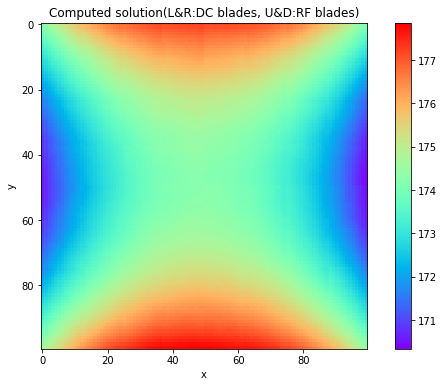

In [38]:
# The next command ensures that plots are shown within the IPython notebook
%matplotlib inline

import matplotlib
from matplotlib import pylab as plt


# Filter out solution values that are associated with points outside the unit circle.
u_evaluated = u_evaluated.reshape((n_grid_points,n_grid_points))
u_evaluated[(u_evaluated>300)|(u_evaluated<0)] = np.nan #去除异常值

# Plot the image

plt.figure(figsize=(10,6))
# cmap = sns.diverging_palette(220, 20, n=7,as_cmap=True)
data = u_evaluated.T
plt.imshow(data,aspect=1.0,cmap='rainbow')
plt.title('Computed solution(L&R:DC blades, U&D:RF blades)')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

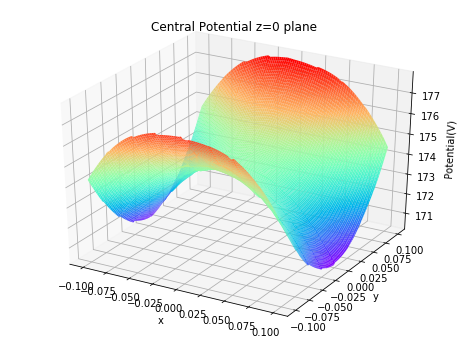

In [39]:
import mpl_toolkits.mplot3d
import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

plt.figure(figsize=(8,6))
ax=plt.subplot(111,projection='3d')
ax.plot_surface(plot_grid[0],plot_grid[1],u_evaluated,rstride=1,cstride=1,cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Potential(V)')
plt.title("Central Potential z=0 plane")
p.show()

## yz平面

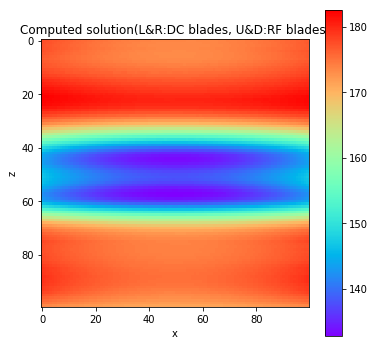

In [40]:
u_yz = u_yz.reshape((n_grid_points,n_grid_points))


# Plot the image

plt.figure(figsize=(6,6))
# cmap = sns.diverging_palette(220, 20, n=7,as_cmap=True)
data = u_yz.T
plt.imshow(data,aspect=1.0,cmap='rainbow')
plt.title('Computed solution(L&R:DC blades, U&D:RF blades)')
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar()

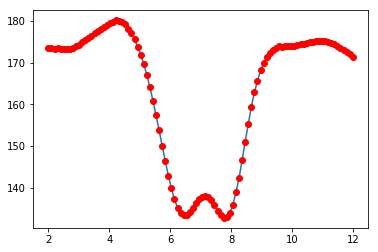

In [41]:
plt.plot(np.linspace(2, 12, n_grid_points), u_yz[50,:])
plt.plot(np.linspace(2, 12, n_grid_points), u_yz[50,:],'ro')
# u_yz[0,0]

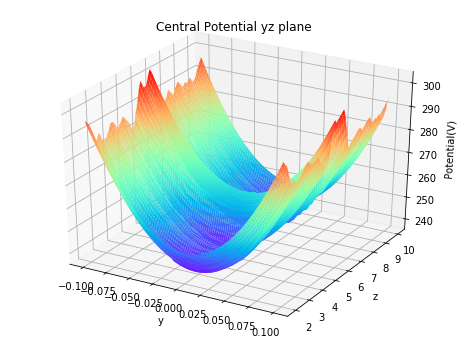

In [25]:
import mpl_toolkits.mplot3d
import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

plt.figure(figsize=(8,6))
ax=plt.subplot(111,projection='3d')
ax.plot_surface(yz_grid[0],yz_grid[1],u_yz,rstride=1,cstride=1,cmap='rainbow')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_zlabel('Potential(V)')
plt.title("Central Potential yz plane")
p.show()

## 8. Psudo potential
RF刀片上本来加的是振荡的电场,电势是含时的
$$\Phi_v(t) = \frac{V_0cos(\Omega_Dt)}{2}(1+\frac{x^2-y^2}{R^2})$$
电场也是含时的$$E(x,y,t)=-\nabla\Phi_v(t)=-\frac{V_0}{R^2}(x\hat{x}-y\hat{y})cos(\Omega_D t)=-E_0(x,y)cos(\Omega_D t)$$
在模拟时，RF上是固定电压，并没有$cos(\Omega_D t)$，不妨认为$t=0$,并且，$E_0(x,y)$不依赖t。因此可以通过当前模拟的**定态电势**计算出$E_0(x,y)$,进而得到实际囚禁离子时的psudo potential.

$$\Phi_{sp}=\frac{e|E_0(x,y)|^2}{4m\Omega_D^2R^4}$$
理想情况下
$$\Phi_{ideal}=\frac{eV_0^2(x^2+y^2)}{4m\Omega_D^2R^4}$$可以将理想值和实际值对比一下。


In [208]:
Ex, Ey = np.gradient(u_evaluated,0.2/n_grid_points,0.2/n_grid_points)
phi = (Ex**2+Ey**2)*100/(23**2*16*3.14**2)
ideal_phi = 300**2*(plot_grid[0]**2+plot_grid[1]**2)*1e6/0.2**4

In [ ]:
plt.figure(figsize=(8,6))
ax=plt.subplot(111,projection='3d')
ax.plot_surface(plot_grid[0],plot_grid[1],phi,rstride=1,cstride=1,cmap='rainbow')
ax.plot_surface(plot_grid[0],plot_grid[1],ideal_phi,rstride=1,cstride=1,cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Potential(V)')
plt.title("Psudo Potential z=6 plane")
p.show()


## 8.离子运动的稳定条件
离子稳定区域要求a<<1,q<<1.
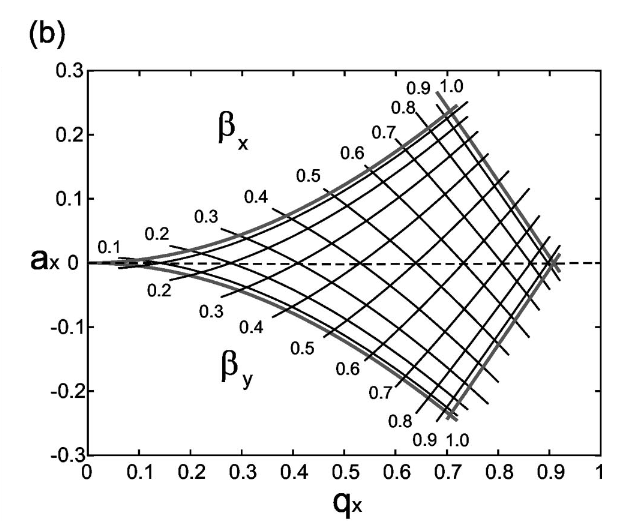

In [162]:
def get_motion_params(rf_volt, dc_volt, rf_freq, R=200):  
    #输入：RF电压rf_volt，DC电压dc_volt，RF频率rf_freq和刀片距离R
    #输出：声子频率w和a，q参数
    Q = 1.60e-19      # unit: C
    m = 171*1.67e-27  # unit: kg
    t = -(4 * Q * dc_volt) * 1e12/(m * (2 * np.pi * rf_freq)**2 * R**2)
    t = round(t, 3)
    a = [t, t, -2*t]  # a参数,无量纲
    t = -2 * Q * rf_volt * 1e12/(m * (2 * np.pi * rf_freq)**2 * R**2)
    t = round(t, 3)
    q = [t, -t, 0]  #q参数，无量纲
    
    wx = (Q * rf_volt)*1e6/(np.sqrt(2) * m * 2 * np.pi * rf_freq * R**2)/6.28 # x-y方向声子频率(不含2pi)，unit:MHz
    wz = np.pi * rf_freq * np.sqrt(a[2]) * 1e-6 / 6.28
    return wx, wx, wz,a,q

In [164]:
wx, wy, wz, a,q = get_motion_params(rf_volt=100, dc_volt=5, rf_freq=23e6, R=200)
print "声子频率 w = 2*pi*[{:.2f},{:.2f},{:.2f}]MHZ".format(wx, wy, wz)
print "a参数 a = {}".format(a)
print "q参数 q = {}".format(q)
print "稳定条件: a<<1, |q|<<1"

声子频率 w = 2*pi*[1.09,1.09,1.86]MHZ
a参数 a = [-0.013, -0.013, 0.026]
q参数 q = [-0.134, 0.134, 0]
稳定条件: a<<1, |q|<<1


In [174]:
row = [[1],[2]]
column=[1,2,3]
grid = np.mgrid[1:2:2*1j, 1:3:3*1j]
# np.gradient(np.array([[1, 2, 6], [3, 4, 5]], dtype=float), grid)
grid

array([[[ 1.,  1.,  1.],
        [ 2.,  2.,  2.]],

       [[ 1.,  2.,  3.],
        [ 1.,  2.,  3.]]])

In [170]:
plot_grid = np.mgrid[-0.1:0.1:n_grid_points*1j,     # 指定x范围，1j不表示虚数，而是指grid包含两个端点。
                     -0.1:0.1:n_grid_points*1j]